# Growth modes

In [ ]:
!make -C .. agglomeration_extracts

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pylandstats as pls
import swisslandstats as sls
from scipy import ndimage as ndi

from swiss_urbanization.data import settings

In [ ]:
urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

agglomeration_slugs = ['bern', 'lausanne', 'zurich']

In [ ]:
agglomeration_dict = {}
for agglomeration_slug in agglomeration_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglomeration_slug}.csv')
    landscapes = []
    dates = []
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        landscapes.append(
            pls.Landscape(
                ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                res=ldf.res, nodata=nodata))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(
            ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0])
    agglomeration_dict[agglomeration_slug] = pls.SpatioTemporalAnalysis(
        landscapes, dates=dates)

In [ ]:
kernel_moore = ndi.generate_binary_structure(2, 2)

def new_patches_label(
        landscape_base_arr, landscape_prime_arr, urban_class):
    new_patches_arr = (landscape_prime_arr == urban_class) & \
                      (landscape_base_arr != urban_class)
    return ndi.label(new_patches_arr, kernel_moore)

def compute_patch_areas(label_arr):        
    return np.bincount(label_arr.ravel())[1:]
    
def compute_patch_leis(label_arr, num_patches, landscape_prime_arr,
                       urban_class, nonurban_class):
    patch_leis = []
    for k in range(1, num_patches + 1):
        patch_arr = label_arr == k
        buffer_zone_arr = ndi.binary_dilation(
            patch_arr, kernel_moore) & ~patch_arr
        buffer_classes = landscape_prime_arr[buffer_zone_arr]
        area_urban = np.sum(buffer_classes == urban_class)
        area_nonurban = np.sum(buffer_classes == nonurban_class)
        patch_leis.append(area_urban / (area_urban + area_nonurban))

    return patch_leis

In [ ]:
def area_weighted_count(patch_areas, cond):
    return np.sum(patch_areas[cond]) / np.sum(patch_areas)

def plot_growth_modes(sta, urban_class, nonurban_class,
                      weight='number', ax=None, subplots_kws={}):
    if ax is None:
        fig, ax = plt.subplots(**subplots_kws)

    t_range = range(len(sta) - 1)
    # grouped bar plot idea from Chris Albon https://bit.ly/2JrybQ5
    pos = list(t_range)
    width = .25

    leapfrogs = np.zeros(len(t_range))
    edge_expansions = np.zeros(len(t_range))
    infills = np.zeros(len(t_range))
    for t in t_range:
        landscape_base_arr = sta.landscapes[t].landscape_arr
        landscape_prime_arr = sta.landscapes[t + 1].landscape_arr
        label_arr, num_patches = new_patches_label(
            landscape_base_arr, landscape_prime_arr, urban_class)
        patch_leis = np.array(
            compute_patch_leis(label_arr, num_patches, landscape_prime_arr,
                               urban_class, nonurban_class))

        leapfrog_cond = np.isclose(patch_leis, 0)
        edge_expansion_cond = (patch_leis > 0) & (patch_leis <= .5)
        infill_cond = patch_leis > .5
        
        if weight == 'number':
            leapfrog = np.sum(leapfrog_cond) / num_patches
            edge_expansion = np.sum(edge_expansion_cond) / num_patches
            infill = np.sum(infill_cond) / num_patches
        else:  # 'area'
            patch_areas = compute_patch_areas(label_arr)
            leapfrog = area_weighted_count(patch_areas, leapfrog_cond)
            edge_expansion = area_weighted_count(
                patch_areas, edge_expansion_cond)
            infill = area_weighted_count(patch_areas, infill_cond)

        leapfrogs[t] = leapfrog
        edge_expansions[t] = edge_expansion
        infills[t] = infill

    ax.bar(pos, leapfrogs * 100, width, label='leapfrog')
    ax.bar([p + width for p in pos], edge_expansions * 100, width,
           label='edge-expansion')
    ax.bar([p + 2 * width for p in pos], infills * 100, width,
           label='infilling')
    
    # if weight == 'number':
    #     ax.set_ylabel('% patch number')
    # else:  # 'area'
    #     ax.set_ylabel('% area')
    ax.set_xticks([p + width for p in pos])
    ax.set_xticklabels(
        ['{}-{}'.format(sta.dates[t], sta.dates[t+1]) for t in t_range])
    # ax.legend()
    
    return ax

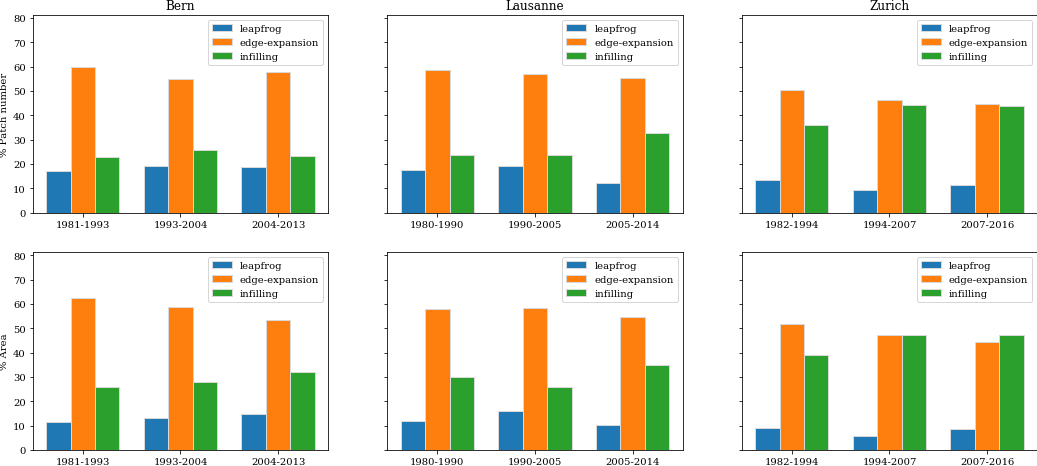

In [ ]:
num_agglomerations = len(agglomeration_dict)
num_cols = num_agglomerations
num_rows = 2  # by patch number and by area

figwidth, figheight = plt.rcParams['figure.figsize']
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    sharey=True,
    figsize=(num_cols * figwidth, num_rows * figheight))

for i, agglomeration_slug in enumerate(agglomeration_slugs):
    agglomeration_sta = agglomeration_dict[agglomeration_slug]
    
    # first plot (above) - by patch number
    ax = axes[0][i]
    ax.set_title(agglomeration_slug.capitalize())
    plot_growth_modes(agglomeration_sta, urban_class, nonurban_class,
                      weight='number', ax=ax)
    ax.margins(y=.3)
    ax.legend()

    # second plot (below) - by area
    ax = axes[1][i]
    plot_growth_modes(agglomeration_sta, urban_class, nonurban_class,
                      weight='area', ax=ax)
    ax.margins(y=.3)
    ax.legend()

fig.axes[0].set_ylabel('% Patch number')
fig.axes[num_cols].set_ylabel('% Area')
fig.savefig('../reports/figures/growth_modes.pdf')